# Dauphine PSL - Master IASD app

# CNNs for Image classification and Transfer Learning

- Lab duration: 1.30h
- Goal: design CNN architecture and illustrate of how transfer learning leverages CNNs training
- TensorBoard -> monitoring training

## Import funtions

In [1]:
%load_ext tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available else "cpu"
device

device(type='cuda')

## Utils function

The following cell contains utils functions that will be useful for the lab session

In [2]:
def display_images(images_, labels_, rows_, cols_, classes, additional_input_=''):#sample here is an image from a dataset tfds
  fig = plt.figure(figsize=(8,8))
  images_ = images_.transpose(1,-1).numpy()
  images_ = (images_ - images_.min()) / (images_.max() - images_.min())
  for img in range(rows_*cols_):
    ax = fig.add_subplot(rows_,cols_,1+img)
    ax.imshow(images_[img])
    ax.set_axis_off()
    if additional_input_!='':
      ax.set_title(str(classes[labels_[img].item()])+ ' vs: ' +str(additional_input_[img]))
    else:
      ax.set_title(str(classes[labels_[img].item()]))

## Dataset import

In this lab session, we will use a [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) a 37 category pet dataset with roughly 200 images for each class.

This dataset is available in `torchvision.datasets` calling the `OxfordIIITPet`.

The following cell will import the `trainval` split of the dataset and outputs a PyTorch `Dataset` object in the variable `dataset`.


In [3]:
dataset = datasets.OxfordIIITPet(root='.', download=True, split="trainval")
image, label = dataset[0]

100%|██████████| 791918971/791918971 [00:37<00:00, 21348928.86it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10975042.98it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


The images in the dataset are in `PIL` format, you will have to use transforms to build your dataset.

<class 'PIL.Image.Image'>


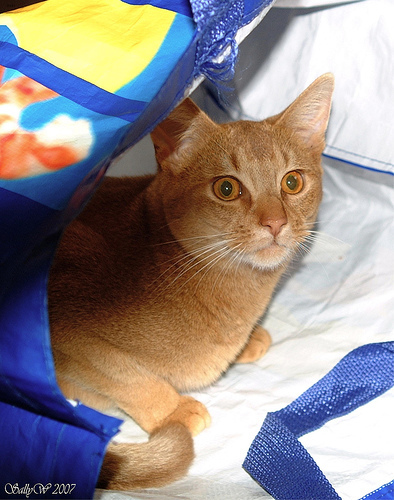

In [ ]:
print(type(image))
image

🛠 **EXERCICE :** Construct train and test dataset using `torchvision.datasets.OxfordIIITPet`.
You will add the following list of transforms
- Resize to size 256
- Center Crop to size 224
- Random Horizontal Flip (p=0.3) **(only for train set)**
- ToTensor transform
- Normalization with respect to ImageNet `mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225]`

⚠️ Normalization with respect to ImageNet is important while using transfer learning. The model's weights have been trained on ImageNet and then we need to normalize our data according to ImageNet training set distribution.


💡 Hint
- You can use the function `transforms.Compose` that enables to chain multiple transforms
- See [torchvision.transforms documentation](https://pytorch.org/vision/stable/transforms.html) construction your data augmentation pipeline (you will find the transforms you need: `transforms.Resize`, `transforms.ToTensor()`, etc)


In [4]:
#YOUR ANSWER HERE
from torchvision.datasets import OxfordIIITPet

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.OxfordIIITPet(root='.', download=True, split="trainval", transform=train_transform)
test_dataset = datasets.OxfordIIITPet(root='.', download=True, split="test", transform=test_transform)

print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 3680
Test dataset length: 3669


## Building DataLoader

🛠 **EXERCICE :** Define your dataloaders for training and test set. Use the `DataLoader` function in `torch.utils.data`

In [5]:
#YOUR ANSWER HERE
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("Number of batches in training loader:", len(train_loader))
print("Number of batches in test loader:", len(test_loader))


Number of batches in training loader: 58
Number of batches in test loader: 58


Run the following cell to visualize a batch

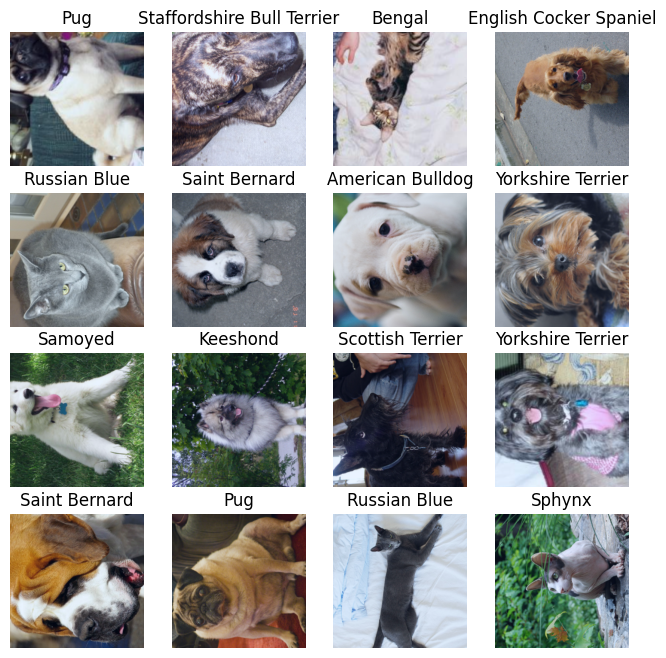

In [6]:
classes = train_dataset.classes

images, labels = next(iter(train_loader))
display_images(images, labels, 4, 4, classes, additional_input_='')

## Training a ResNet18 from scratch

In this firdt part, we will built a resnet18 architecture and train it from scratch. "From scratch" means that we will not use transfer learning and not load the pretrained weights.

In the Figure bellow, we display the architecture of a ResNet18


<br>
<center><img src="https://drive.google.com/uc?export=view&id=1ywhHZxGBxpNjmrX3jHHGqQkvyaKgljKN"width="700"/></center>



### Importing ResNet18 architecture

A lot of architecture are available with their respective pretained weights in `torchvision.models` for different tasks
- classification
- semantic segmentation
- object detection
- instance segmentation

Here we are interested in classification architectures.

See the [torchvision.models documentation](https://pytorch.org/vision/0.8/models.html) for more models

🛠 **EXERCICE :** Import a ResNet18 model without pretrained weights

In [7]:
#YOUR ANSWER HERE
import torchvision.models as models
model = models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Run the following cell to see in details the model architecture

In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The model available in `torchvision` is designed for ImageNet dataset, which contains 1000 classes. We can see the fully connected layer:
```python
(fc): Linear(in_features=512, out_features=1000, bias=True)
```
We will need to adapt the Fully Connected layer to our dataset that contains 37 classes


🛠 **EXERCICE :** replace the fully connected layer with the following fully connected layers
- Linear(?,256)
- ReLU activation function
- Dropout with parameter 0.4
- Linear(256,37)

💡 Hint
- you can get the number of input features using `model.fc.in_features`
- use `nn.Sequential` to chain the layers

In [ ]:
num_features = model.fc.in_features

new_fc_layers = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, 37)
)

model.fc = new_fc_layers
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Run the next cell to see the number of trainable parameters of the model

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {trainable_params} trainable parameters")

The model has 11317349 trainable parameters


💡 The following method `model.parameters()` create a generator with all the parameters of the model. Hence, all the parameters with `.requires_grad=True` are trainable, it means that the tensor will use the gradient for updating the weights

### training and validation functions using TensorBoard

In this part, you will have to implement
- a function `train` that trains the model over a `DataLodaer`
- a function `validate` function that evaluate the model over a `DataLodaer`

For the several experiments of this notebook, we will use `TensorBoard` to monitor the training and evaluation.

To log the metrics in TensorBoard, you need to create a `SummaryWriter` object.

```python

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('your_experiment')
```

Then log the losses and metrics using the module `add_scalar` of your `writer`. Here is an example:

```python
writer.add_scalar('your_metric',
                  your_metric_variable,
                  step)
```

The code above means that the writer will log `your_metric_variable` into ```"your_metric"``` at a given step (iteration or epoch)


For more documentation
- [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html)
- [tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)



🛠 **EXERCICE :** Implement the `train` and `evaluate` functions

In [9]:
import torch.optim as optim

def train(model, loader, epoch, optimizer, log_interval=200, writer=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(images)}/{len(loader.dataset)} "
                  f"({100. * batch_idx / len(loader):.0f}%)]\tLoss: {loss.item():.6f}")
            if writer:
                writer.add_scalar('training loss', loss.item(), epoch * len(loader) + batch_idx)
    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100 * correct / total
    print(f'Training Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.2f}%')
    return epoch_loss

@torch.no_grad()
def validate(model, loader, loss_vector, accuracy_vector, step="Validation", writer=None):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    val_loss /= len(loader)
    print(f'{step} loss: {val_loss:.6f}, Accuracy: {accuracy:.2f}%')
    if writer:
        writer.add_scalar(f'{step} loss', val_loss)
        writer.add_scalar(f'{step} accuracy', accuracy)
    loss_vector.append(val_loss)
    accuracy_vector.append(accuracy)
    return val_loss, accuracy


### train your model

Now you have implemented the `train` and `validate` functions you can train your model.


🛠 **EXERCICE :** train your model using the `train` and `validation` functions implemented above. Use a writer to monitor your training losses et validation metrics.

💡 Hint
You need to
- train the model on 5 epochs
- initialize a `writer` with the following experiment name `"runs/resnet_scratch"`. `runs` corresponds to the folder that `TensorBoard` uses to read the metrics.
- initialize an `optimize`
- define your criterion/loss function

Run the following cell to launch TensorBoard

In [ ]:
%tensorboard --logdir runs

While your model trains, you can see the training updates in `TensorBoard`.

In [11]:
import torch
from torch.utils.tensorboard import SummaryWriter

In [ ]:
%%time

writer = SummaryWriter("runs/resnet_scratch")


#YOUR ANSWER HERE
criterion = nn.CrossEntropyLoss()
model.to(device)
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_loss_vector = []
val_loss_vector = []
train_accuracy_vector = []
val_accuracy_vector = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train(model, train_loader, epoch, optimizer, writer=writer)
    train_loss_vector.append(train_loss)

    val_loss, val_accuracy = validate(model, test_loader, val_loss_vector, val_accuracy_vector, writer=writer)

    writer.add_scalar("Epoch/train_loss", train_loss, epoch)
    writer.add_scalar("Epoch/val_loss", val_loss, epoch)
    writer.add_scalar("Epoch/val_accuracy", val_accuracy, epoch)

# Close the writer
writer.close()

Epoch 1/5
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.546321
Training Loss: 3.552994, Accuracy: 4.84%
Validation loss: 3.524440, Accuracy: 5.53%
Epoch 2/5
Train Epoch: 2 [0/3680 (0%)]	Loss: 3.479483
Training Loss: 3.503954, Accuracy: 5.03%
Validation loss: 3.473916, Accuracy: 6.60%
Epoch 3/5
Train Epoch: 3 [0/3680 (0%)]	Loss: 3.424701
Training Loss: 3.469172, Accuracy: 5.65%
Validation loss: 3.485141, Accuracy: 6.16%
Epoch 4/5
Train Epoch: 4 [0/3680 (0%)]	Loss: 3.372851
Training Loss: 3.420323, Accuracy: 7.15%
Validation loss: 3.380022, Accuracy: 7.50%
Epoch 5/5
Train Epoch: 5 [0/3680 (0%)]	Loss: 3.501837
Training Loss: 3.432874, Accuracy: 6.55%
Validation loss: 3.471237, Accuracy: 7.30%
CPU times: user 4min 34s, sys: 15.3 s, total: 4min 49s
Wall time: 4min 52s


You trained a ResNet18 from scratch without initialization. What can you notice?

**Answer:** The accuracy is low compare to pretrained model

## Transfer Learning : using a pre-trained ResNet18 model as a feature extractor

In this section, we will see how using transfer leverages training
- fast training  
- good performance

In this part, we will use a **pretrained model as a feature extractor**
Recipe
- Download a model pretrained on ImageNet
- Freeze the weights the feature extraction part
- Adapt the Fully Connected layer to the classification task


In this part, we will use a `resnet18` architecture as in the previous section.

🛠 **EXERCICE :** Construct an architecture using transfer learning feature extraction? </br>
You will use a `resnet18` pretrained with ImageNet


💡 Hint
- for using a pretrained model, you can specifiy the parameter `pretrained=True`
- You need to freeze the weights of the feature extractor block of the model. It means that the gradient will not be backpropagated within this layers. Here is a way to do it:
using a PyTorch model named `model`, you can access its parameters using `model.parameters()`, which returns a generator with all the parameters of the model. Then for each parameter, you can deactivate the gradient requirement ```param.requires_grad=False```

```python
for param in model.parameters():
    param.requires_grad = False
```

In [ ]:
#YOUR ANSWER HERE
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

new_fc_layers = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, 37)
)

model.fc = new_fc_layers

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The following cell gives you the number of trainable parameters

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {trainable_params} trainable parameters")

The model has 140837 trainable parameters


In [ ]:
trainable_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"The model has {trainable_params} trainable parameters")

The model has 140837 trainable parameters


🛠 **EXERCICE :** Initialize a `SGD` optimizer with learning rate parameter of 0.01

In [ ]:
#YOUR ANSWER HERE
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
%tensorboard --logdir runs

🛠 **EXERCICE :** train your model on 5 epochs

In [ ]:
%%time
epochs = 5

writer = SummaryWriter("runs/resnet_feature_extractor")

criterion = nn.CrossEntropyLoss()
model.to(device)
epochs = 5
optimizer = optimizer

train_loss_vector = []
val_loss_vector = []
train_accuracy_vector = []
val_accuracy_vector = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train(model, train_loader, epoch, optimizer, writer=writer)
    train_loss_vector.append(train_loss)

    val_loss, val_accuracy = validate(model, test_loader, val_loss_vector, val_accuracy_vector, writer=writer)

    writer.add_scalar("Epoch/train_loss", train_loss, epoch)
    writer.add_scalar("Epoch/val_loss", val_loss, epoch)
    writer.add_scalar("Epoch/val_accuracy", val_accuracy, epoch)

writer.close()

Epoch 1/5
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.673028
Training Loss: 3.502929, Accuracy: 8.59%
Validation loss: 3.318985, Accuracy: 28.35%
Epoch 2/5
Train Epoch: 2 [0/3680 (0%)]	Loss: 3.362141
Training Loss: 3.174989, Accuracy: 25.87%
Validation loss: 2.931478, Accuracy: 56.23%
Epoch 3/5
Train Epoch: 3 [0/3680 (0%)]	Loss: 2.941303
Training Loss: 2.764514, Accuracy: 43.10%
Validation loss: 2.471467, Accuracy: 66.67%
Epoch 4/5
Train Epoch: 4 [0/3680 (0%)]	Loss: 2.486222
Training Loss: 2.346929, Accuracy: 53.42%
Validation loss: 2.020580, Accuracy: 74.35%
Epoch 5/5
Train Epoch: 5 [0/3680 (0%)]	Loss: 2.111985
Training Loss: 1.956856, Accuracy: 59.86%
Validation loss: 1.652669, Accuracy: 77.81%
CPU times: user 4min 2s, sys: 15.5 s, total: 4min 18s
Wall time: 4min 18s


## Transfer Learning : fine-tuning a ResNet18 model

In this section, we will use transfer learning to fine tune the resnet18 pre-trained architecture.

In this part, we will use a **pretrained model as a feature extractor** and also **enable training on the last convolutional block**.
The idea is to train only the high level features of the pretrained model.

Recipe
- Download a model pretrained on ImageNet
- Freeze the weights the feature extraction part except the last layer : **layer4**
- Adapt the Fully Connected layer to the classification task


🛠 **EXERCICE :** Construct an architecture using transfer learning and fine-tune the resnet18 </br>

💡 Hint

- To access the parameters of the 4th layer, you can use `model.layer4.parameters()`
- You have to set the gradients requirement of these layers to `True`

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True


num_features = model.fc.in_features

new_fc_layers = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, 37)
)

model.fc = new_fc_layers

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {trainable_params} trainable parameters")

The model has 8534565 trainable parameters


In [ ]:
trainable_params = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
print(f"The model has {trainable_params} trainable parameters")

The model has 8534565 trainable parameters


More trainables parameters than transfer learning using feature extraction
- resnet from scratch : **11 317 349** trainable parameters
- resnet feature extraction : **140 837** trainable parameters
- resnet fine tuning layer 4 : **8 534 565** trainable parameters

🛠 **EXERCICE :** train your model your fine-tuned resnet18
- on 5 epochs
- using a `SGD` optimizer
- same criterion/loss function as before

In [ ]:
%tensorboard --logdir runs

In [ ]:
%%time
epochs = 5

writer = SummaryWriter("runs/resnet_fine_tuned")

criterion = nn.CrossEntropyLoss()
model.to(device)
epochs = 5
#optimizer = optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)

train_loss_vector = []
val_loss_vector = []
train_accuracy_vector = []
val_accuracy_vector = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train(model, train_loader, epoch, optimizer, writer=writer)
    train_loss_vector.append(train_loss)

    val_loss, val_accuracy = validate(model, test_loader, val_loss_vector, val_accuracy_vector, writer=writer)

    writer.add_scalar("Epoch/train_loss", train_loss, epoch)
    writer.add_scalar("Epoch/val_loss", val_loss, epoch)
    writer.add_scalar("Epoch/val_accuracy", val_accuracy, epoch)

writer.close()

Epoch 1/5
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.672188
Training Loss: 2.022556, Accuracy: 39.38%
Validation loss: 1.918310, Accuracy: 51.51%
Epoch 2/5
Train Epoch: 2 [0/3680 (0%)]	Loss: 1.040154
Training Loss: 1.108561, Accuracy: 63.72%
Validation loss: 1.448711, Accuracy: 57.15%
Epoch 3/5
Train Epoch: 3 [0/3680 (0%)]	Loss: 1.196641
Training Loss: 0.846232, Accuracy: 72.91%
Validation loss: 1.510411, Accuracy: 63.12%
Epoch 4/5
Train Epoch: 4 [0/3680 (0%)]	Loss: 0.435669
Training Loss: 0.728870, Accuracy: 77.66%
Validation loss: 0.902155, Accuracy: 73.26%
Epoch 5/5
Train Epoch: 5 [0/3680 (0%)]	Loss: 0.434976


What can you notice regarding the performance of a fine-tuned resnet18 compared to
- resnet trained from scratch
- resnet trained as a feature extractor?

**Result:** It really depends on the learning rate that I apply to these networks.

**Fine-tuning:** If I apply SGD with a large learning rate (0.01) during fine-tuning, as applied in the feature extractor, the results are quite unstable (around 5% accuracy). However, with a moderate learning rate of 0.005, the results are impressive, even compared to the feature extractor. One reason I can point out is the large number of learnable parameters, which necessitates using a smaller learning rate to make gradual adjustments at each step, rather than making drastic changes with a high learning rate.

**Feature extractor:** The number of learnable parameters is much smaller compared to fine-tuning, allowing for a wider range of choices for the learning rate in the initial epochs.

## Conclusion

In this lab session, you have seen how transfer transfer learning can save time and computational resources, as it leverages the pre-trained model's learned features and weights.

We have compared
- a resnet trained from scratch
- several versions of transfer learning using a resnet
  - a resnet used a a feature extractor
  - a fine-tuned resnet

In fact, transfer learning clearly gives better results than a random initialization training
- faster training
- save time

⚠️ Benchmarking both versions of transfer learning (feature extraction/fine tuning)
- both the methods achieve very good performance
- fine-tuning seems to be faster at learning
- BUT you have to be very careful not to overfit while fine-tuning a model



## Supplementary exercise (if time permits)

In this part, we will try to highlight overfitting issues while using a pretrained model as initialization (we do not freeze any layers of the pretrained model)

🛠 **EXERCICE :** Train a pretrained resnet18, without freezing any layers
- on 10 epochs.
- using a `SGD` optimizer
- same criterion/loss function as before


In [12]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

num_features = model.fc.in_features

new_fc_layers = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, 37)
)

model.fc = new_fc_layers

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.0MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {trainable_params} trainable parameters")

The model has 11317349 trainable parameters


In [15]:
%%time
#I forget to change epochs to 10 so this result is the model after trained with 5 epochs
epochs = 10

writer = SummaryWriter("runs/resnet_no_freeze")

criterion = nn.CrossEntropyLoss()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005)

train_loss_vector = []
val_loss_vector = []
train_accuracy_vector = []
val_accuracy_vector = []

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    train_loss = train(model, train_loader, epoch, optimizer, writer=writer)
    train_loss_vector.append(train_loss)

    val_loss, val_accuracy = validate(model, test_loader, val_loss_vector, val_accuracy_vector, writer=writer)

    writer.add_scalar("Epoch/train_loss", train_loss, epoch)
    writer.add_scalar("Epoch/val_loss", val_loss, epoch)
    writer.add_scalar("Epoch/val_accuracy", val_accuracy, epoch)

writer.close()

Epoch 1/10
Train Epoch: 1 [0/3680 (0%)]	Loss: 2.063386
Training Loss: 2.002071, Accuracy: 62.45%
Validation loss: 1.721120, Accuracy: 78.69%
Epoch 2/10
Train Epoch: 2 [0/3680 (0%)]	Loss: 1.785229
Training Loss: 1.694934, Accuracy: 67.74%
Validation loss: 1.432832, Accuracy: 81.30%
Epoch 3/10
Train Epoch: 3 [0/3680 (0%)]	Loss: 1.708803
Training Loss: 1.437919, Accuracy: 71.82%
Validation loss: 1.224412, Accuracy: 82.56%
Epoch 4/10
Train Epoch: 4 [0/3680 (0%)]	Loss: 1.355583
Training Loss: 1.238095, Accuracy: 75.27%
Validation loss: 1.055817, Accuracy: 84.41%
Epoch 5/10
Train Epoch: 5 [0/3680 (0%)]	Loss: 1.073763
Training Loss: 1.075911, Accuracy: 78.48%
Validation loss: 0.933393, Accuracy: 84.98%
Epoch 6/10
Train Epoch: 6 [0/3680 (0%)]	Loss: 0.912385


KeyboardInterrupt: 